## EE512 – Applied Biomedical Signal Processing
# Practical session – Linear Models II - Answers
### Instructions
* This notebook provides all the questions of the practical session and the space to answer them. We recommend working directly here and then exporting the document as your report.
* Include any code used when addressing the questions, together with your answers.
* Please submit your report as a single PDF file.
* We recommend working in a group of 4–5 students; you must prepare one single report for the group (`name1_name2_name3_name4_name5_lab_LinearModelsII.pdf`), but every member needs to upload the same file individually.

In [1]:
%matplotlib widget

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import resample, welch, correlate
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.ar_model import AutoReg

# File paths
fhr1 = os.path.join(os.getcwd(), 'data', 'heart_1.dat')
fhr2 = os.path.join(os.getcwd(), 'data', 'heart_2.dat')
fem1 = os.path.join(os.getcwd(), 'data', 'emg1.dat')
fem2 = os.path.join(os.getcwd(), 'data', 'emg2.dat')
fppg = os.path.join(os.getcwd(), 'data', 'ppg.dat')
feeg = os.path.join(os.getcwd(), 'data', 'eeg_stim.dat')

### Experiment 1: parametric spectral estimation of cardiorespiratory signals
The file `/data/heart_1.dat` contains three physiological signals: RR-interval, arterial pressure and respiration, in this order (sampled at 4 Hz). The recordings were made in a patient at rest. In the spectral domain, this RR-interval signal is expected to show a peak around 0.08 Hz, corresponding to the *baroreflex* (regulation between arterial blood pressure and heart rate), and a peak at 0.225 Hz, corresponding to the *breathing rate* (heart rhythm modulation by respiration, the so-called *“sinus arrhythmia”*) – see `/data/readme_heart.txt` for more details.

We start by importing the signals, subsampling to 1 Hz, and removing their averages:

In [2]:
with open(fhr1, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    rr1 = np.array([float(s[0]) for s in txt])
    bp1 = np.array([float(s[1]) for s in txt])
    rs1 = np.array([float(s[2]) for s in txt])

df = 4
rr1 = resample(rr1, int(len(rr1)/df))
bp1 = resample(bp1, int(len(bp1)/df))
rs1 = resample(rs1, int(len(rs1)/df))

for y in [rr1, bp1, rs1]:
    y -= np.mean(y)

AR modeling provides tools for extracting various useful estimates from a signal, in a so-called *parametric* way, because the estimates are based on the model parameters, rather than on the raw signal itself. The function defined below implements the estimation of the signal spectral density based on its AR parameters.

In [3]:
def ar_psd(arg1, arg2, arg3, n=1000):
    """
    Parametric spectral density estimation based on AR modeling
    
    Inputs:
        arg1: ?
        arg2: ?
        arg3: ?
        n: defines the spectral sampling
    
    Outputs:
        arg4: ?
        arg5: ?
    """
    
    arg5 = np.arange(n) * arg3/2/n
    aar, sg = yule_walker(arg1, order=arg2, method="mle")
    
    a = complex(1)
    for k in range(1,arg2+1):
        a += -aar[k-1] * np.exp(-2*np.pi*k*1j*arg5/arg3)
    
    arg4 = sg**2 / (arg3 * np.abs(a)**2)
    
    return arg4, arg5

**Question 1.1.** The implementation above has an incomplete docstring (help text), and the input and output arguments have generic names (`arg1-5`). Copy the function to the answer space below, complete the help, and replace the argument names by more intuitive choices, based on what you've learned in the theory.

**Answer 1.1.** *The function can be completed as follows:*

In [4]:
def ar_psd_rn(x, p, fs, n=1000):
    """
    Parametric spectral density estimation based on AR modeling
    
    Inputs:
        x: Input signal in the time domain
        p: AR model order
        fs: Sampling frequency, in Hz
        n: defines the spectral sampling
    
    Outputs:
        psd: power spectral density
        f: frequency axis for psd, of length n, in Hz
    """
    
    f = np.arange(n) * fs/2/n
    aar, sg = yule_walker(x, order=p, method="mle")
    
    a = complex(1)
    for k in range(1,p+1):
        a += -aar[k-1] * np.exp(-2*np.pi*k*1j*f/fs)
    
    psd = sg**2 / (fs * np.abs(a)**2)
    
    return psd, f

We now use this tool to obtain the spectral density of the three signals. Below, we explore the results obtained with different AR model orders: 5, 15, 40.

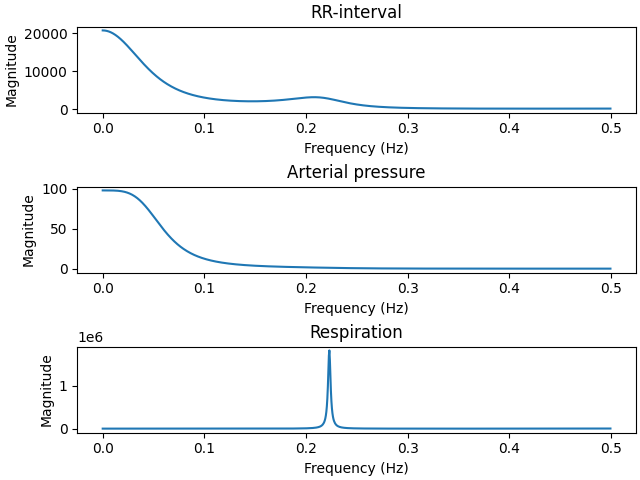

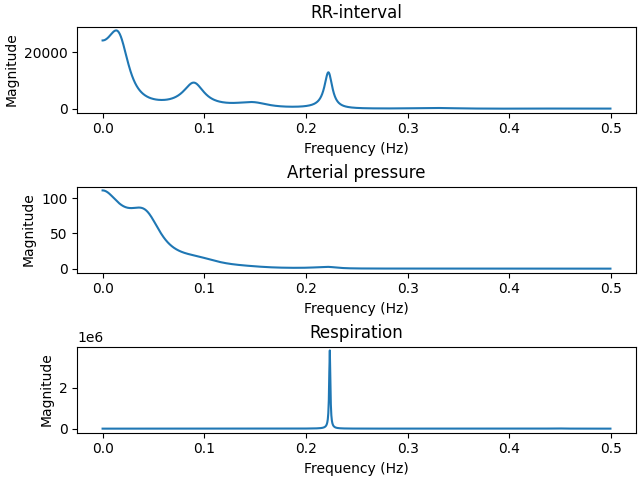

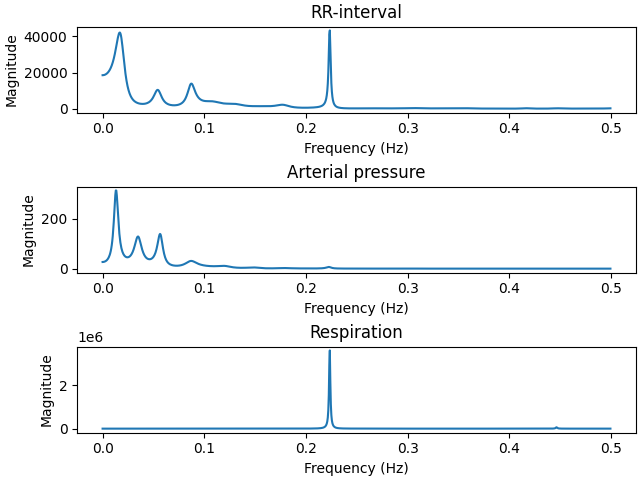

In [5]:
y = [rr1, bp1, rs1]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

for p in (5, 15, 40):
    
    plt.figure(constrained_layout=True)
    
    for k in range(3):
        
        py, f = ar_psd(y[k], p, 1.0)
        
        plt.subplot(3,1,k+1)
        plt.plot(f, py)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(ttl[k])

**Question 1.2.** How does the order affect the spectra? Given the physiological description of the expected peaks for the RR-interval, what is the most suitable order choice?

**Answer 1.2.** *It should be observed that increasing the order generally leads to more flexible but also more intricate spectra, with increasing presence of oscillations/“peaks”. Based on the description of the expected peaks in the RR-interval spectrum, the intermediate order of 15 appears to be the most reliable; at order 5 the two peaks are difficult/impossible to distinguish; at order 40 several others appear, hindering the interpretation.*

We can now perform a *non-parametric* spectral estimation of the same signals, using for instance Welch’s method:

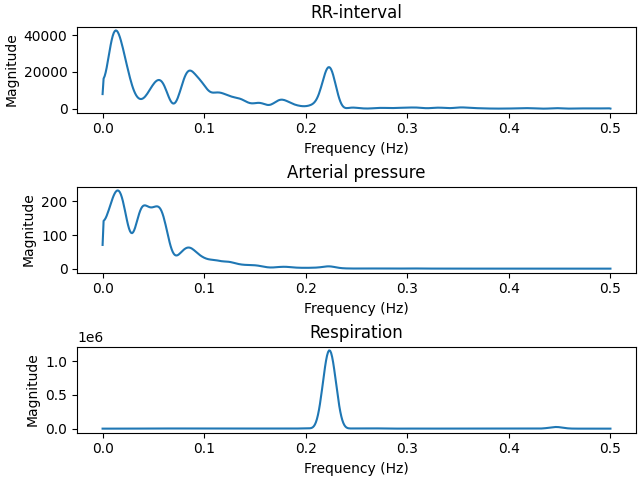

In [6]:
y = [rr1, bp1, rs1]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

plt.figure(constrained_layout=True)

for k in range(3):
    
    f, py = welch(y[k], fs=1.0, nperseg=100, scaling='density', nfft=1000)
    
    plt.subplot(3,1,k+1)
    plt.plot(f, py)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(ttl[k])

**Question 1.3.** Explain how Welch's method works (it may be helpful to consult the help of `welch`), and the fundamental differences between this approach and the AR parametric method.

**Answer 1.3.** *The answer can describe that the Welch method consists in dividing the signal timecourse in a number of segments (which can overlap if desired), obtaining the power spectral density from each segment (for example by taking the Fourier transform (FT) of each segment and computing its squared magnitude), and then combining these estimates across segments, e.g. as the average or median. The AR-based method relies on AR modeling of the signal (for a specified order p) to then extract the PSD based strictly on the model parameters (the original signal is not used). Thus, the Welch method is based on the signal alone and does not make any assumptions about its temporal structure, while the AR-based method makes the assumption that the signal is well modeled by an AR model of a specific order *p*.*

**Question 1.4.** In our particular problem, how do the spectra obtained with Welch's method compare with those of the parametric approach (order 15)? Given the previous RR-interval description, which approach performs most reliably?

**Answer 1.4.** *It should be observed that the non-parametric approach  generates more complex plots, with more peaks in the spectral profile, similar to the case of the parametric approach when the AR order is set too high. While it is not possible to say without doubt which approach is more accurate, the parametric approach at order 15 clearly appears to be more consistent with the expectations described in the question for the RR-interval signal. This also supports the idea that parametric approaches can be more robust and accurate than non-parametric methods by conditioning their estimates with prior assumptions about the signal – as long as the model is adequate to the problem.*

We now consider the signals in `/data/heart_2.dat`, which are recordings from the same individual after alcohol consumption.

In [7]:
with open(fhr2, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    rr2 = np.array([float(s[0]) for s in txt])
    bp2 = np.array([float(s[1]) for s in txt])
    rs2 = np.array([float(s[2]) for s in txt])

**Question 1.5.** Repeat the processing steps done for `heart_1.dat` to obtain a parametric spectral estimation (order 15). Which of the physiological mechanisms described for the RR-interval was most disrupted by alcohol? And what other changes do you observe in the physiological signals?

**Answer 1.5.** *The new signal can be analysed as follows:*

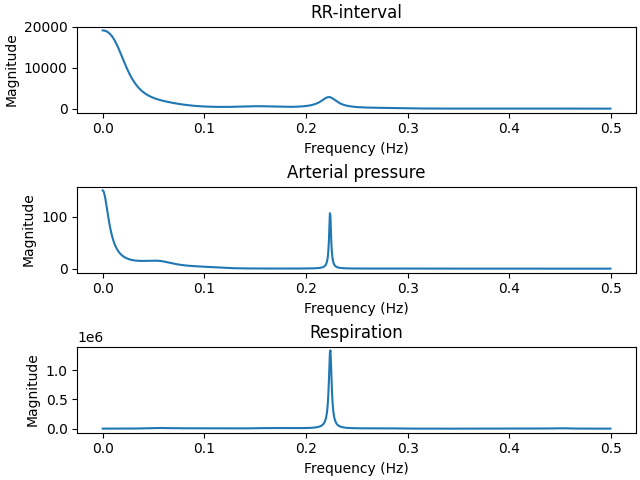

In [8]:
df = 4
rr2 = resample(rr2, int(len(rr2)/df))
bp2 = resample(bp2, int(len(bp2)/df))
rs2 = resample(rs2, int(len(rs2)/df))

for y in [rr2, bp2, rs2]:
    y -= np.mean(y)

y = [rr2, bp2, rs2]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

plt.figure(constrained_layout=True)

for k in range(3):
    
    py, f = ar_psd(y[k], 15, 1.0)
    
    plt.subplot(3,1,k+1)
    plt.plot(f, py)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(ttl[k])

It should be noted that there are several clear differences between the pre- and post-alcohol states. For the RR-interval, the peak at 0.08 Hz has mostly disappeared, suggesting an important disruption of the baroreflex mechanism; the peak at 0.225 Hz is partially reduced, suggesting that sinus arrhythmia is affected as well. The arterial pressure becomes more dependent on the respiration (peak appearing at 0.225 Hz). The respiration becomes partially less regular, as can be seen from the widening of the peak.

### Experiment 2: estimating the effects of fatigue on muscle signals
The files `/data/emg1.dat` and `/data/emg2.dat` contain three surface electromyography (sEMG) signals each (1024 Hz sampling frequency). These signals were recorded from the thigh muscle during a 10-min exercise on an ergocycle, respectively from an athlete (`emg1`) and from a moderately trained subject (`emg2`). In each file, the columns correspond to recordings from the *start*, *middle* and *end* of the exercise, respectively.

We start by importing the signals:

In [9]:
with open(fem1, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    em1 = np.zeros((n,3))
    for k in range(3):
        em1[:,k] = [float(s[k]) for s in txt]

with open(fem2, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    em2 = np.zeros((n,3))
    for k in range(3):
        em2[:,k] = [float(s[k]) for s in txt]

fs = 1024.0 # Hz

We first plot the sEMG segments in the time domain. We can observe four bursts in each recording, which correspond to four pedal strokes. The goal of the experiment was to assess the effects of fatigue on the signal properties of the sEMG.

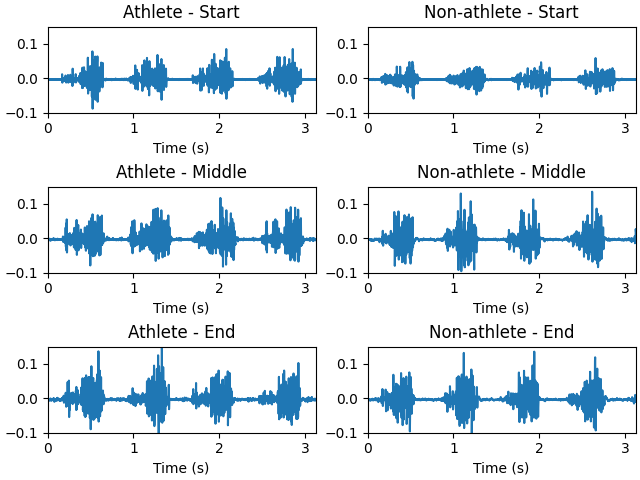

In [10]:
ttl1 = ['Athlete', 'Non-athlete']
ttl2 = ['Start', 'Middle', 'End']
t = np.arange(n) / fs

plt.figure(constrained_layout=True)
for k in range(2):
    
    y = [em1, em2][k]
    
    for l in range(3):
        
        plt.subplot(3,2,2*l+k+1)
        plt.plot(t,y[:,l])
        plt.xlim(t[0], t[-1])
        plt.ylim(-0.10, 0.15)
        plt.xlabel('Time (s)')
        plt.title(ttl1[k] + ' - ' + ttl2[l])

We'll now look at the spectral profile of the signals. Considering, for instance, the start sEMG recording of the athlete, we obtain the parametric power spectral density (PSD) for an AR model of order 30:

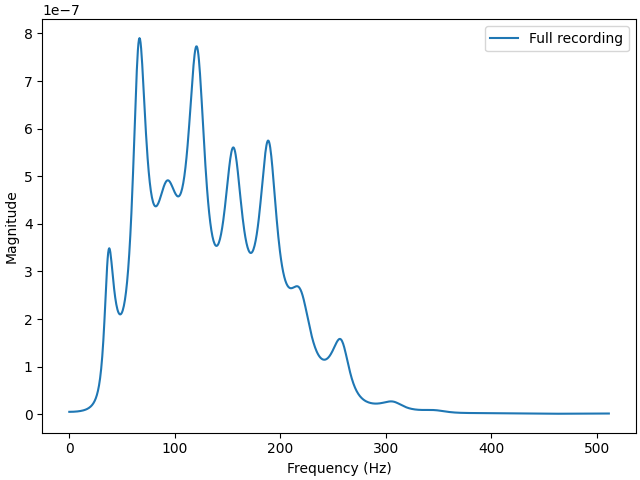

In [11]:
p = 30
pya, fa = ar_psd(em1[:,0], p, fs)

plt.figure(constrained_layout=True)
plt.plot(fa, pya, label='Full recording')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

**Question 2.1.** In principle, it would be more correct to segment each burst and analyze it separately, but it turns out that using the entire recording will yield a relatively similar spectral profile. Check that it is the case: copy the plotting code above to the space below and add (overlayed in the same panel) the PSD obtained from the first burst only, for the same signal. How do their profiles compare? Where does the difference in peak signal-to-noise come from?

**Answer 2.1.** *The new plot can be done as follows:*

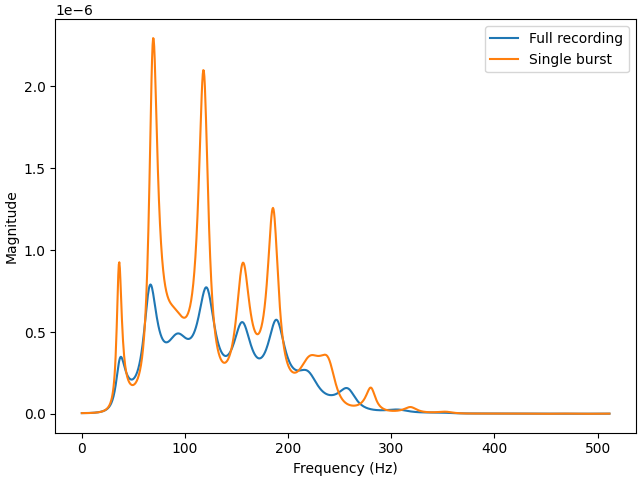

In [12]:
p = 30
pya, fa = ar_psd(em1[:,0], p, fs)
pyb, fb = ar_psd(em1[165:675,0], p, fs)

plt.figure(constrained_layout=True)
plt.plot(fa, pya, label='Full recording')
plt.plot(fb, pyb, label='Single burst')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

*It should be observed that the two spectra have a relatively similar profile, in terms of the most prominent peaks, their location and width. In the full recording, however, the peaks have considerably smaller amplitude. The reason for this outcome is that the full recording contains both the bursts (which contribute to the peaks) and “silent” periods in between; because the spectral power is taken as an average over the provided time window, the estimated power for the peaks is therefore lower when the signal does not contain only the bursts but also silent periods, compared to a window that contains only the burst.*

We now estimate and plot the PSD for every recorded segment of both individuals:

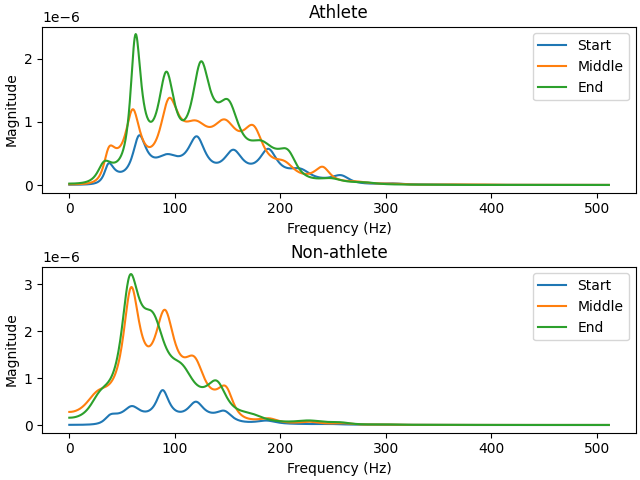

In [13]:
plt.figure(constrained_layout=True)
for k in range(2):
    
    y = [em1, em2][k]
    plt.subplot(2,1,k+1)
    
    for l in range(3):
        
        pya, fa = ar_psd(y[:,l], p, fs)
        plt.plot(fa, pya, label=ttl2[l])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
    
    plt.title(ttl1[k])
    plt.legend()

**Question 2.2.** To complement the above PSD's, estimate the mean frequency using `sum(fa * pya / sum(pya))`. What does this formula express?

**Answer 2.2.** *The mean frequency specified above can be estimated as follows:*

In [14]:
for k in range(2):
    
    y = [em1, em2][k]
    
    for l in range(3):
        
        pya, fa = ar_psd(y[:,l], p, fs)
        
        print(ttl1[k] + ' - ' + ttl2[l] + ': {:.1f}'.format(
            np.sum(fa * pya / np.sum(pya))))

Athlete - Start: 136.5
Athlete - Middle: 127.3
Athlete - End: 121.1
Non-athlete - Start: 106.3
Non-athlete - Middle: 87.9
Non-athlete - End: 87.6


*The provided expression to derive the mean frequency is simply a weighted average of all possible frequencies, where the weighting is provided by the respective power; the sum of all powers is used to normalize the weights to a total sum of 1.*

**Question 2.3.** Based on the PSD plots and the mean frequencies obtained above, what marks the difference between the athlete and the moderately trained subject?

**Answer 2.3.** *As seen in the plots and in the mean frequency, the athlete has lower sEMG power overall, but a higher mean frequency. Notably, the mean frequency is also decreasing less abruptly from the start to the middle than in the moderately trained subject, indicating less fatigue. The PSDs also reflect this observation, where the middle PSD of the non-athlete is already quite similar to the end PSD, whereas in the athlete the evolution is more gradual.*

### Experiment 3: assessment of PPG signal structure
Photoplethysmography (PPG) is a simple, low-cost, non-invasive optical monitoring technique that can be used to detect volumetric changes in blood in the peripheral circulation, by measuring on the skin surface. It can be integrated in wearable devices (e.g. a watch) to monitor a person’s heart rate throughout daily life, and detect potential issues like atrial fibrillation. The file `/data/ppg.dat` contains a PPG recording from a normal cardiac rhythm, and another from a subject in atrial fibrillation (both sampled at 21.3 Hz).

We start by importing and plotting the two signals:

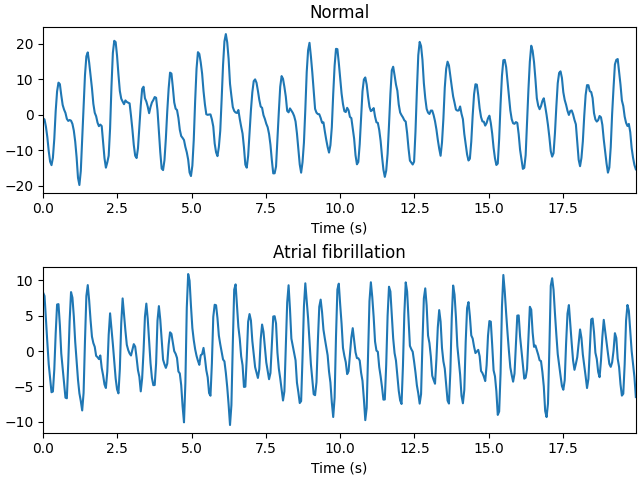

In [15]:
with open(fppg, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    ppg1 = np.array([float(s[0]) for s in txt])
    ppg2 = np.array([float(s[1]) for s in txt])

for y in [ppg1, ppg2]:
    y -= np.mean(y)

fs = 21.3 # Hz

plt.figure(constrained_layout=True)
ttl = ['Normal', 'Atrial fibrillation']

n = len(ppg1)
t = np.arange(n) / fs

for k in range(2):
    
    y = [ppg1, ppg2][k]
    
    plt.subplot(2,1,k+1)
    plt.plot(t, y)
    plt.xlim(t[0], t[-1])
    plt.xlabel('Time (s)')
    plt.title(ttl[k])

Each observed oscillation on the PPG typically corresponds to one pulse, generated by one cardiac cycle. By inspecting the plot above, we can already appreciate how one signal is visibly less regular than the other. AR modeling allows us to quantify the underlying differences with several complementary metrics.

We define again the function `ar_order` introduced in the previous practical session:

In [16]:
def ar_order(x, omax, Aff=0):
    """
    AR order estimation
    x: signal
    omax: maximum possible order
    Aff: 0 no graphic display; 1 display
    
    Returns:
    omdl: order estimated with MDL
    """
    
    nx = len(x)
    s = np.zeros((omax,))
    c = np.zeros((omax,))

    for k in range(omax):
        
        n = k+1
        
        ar_model = AutoReg(x, n, trend='n')
        ar_model_fit = ar_model.fit()
        sg2 = ar_model_fit.sigma2
        
        s[k] = sg2
        c[k] = nx * np.log(sg2) + (n+1) * np.log(nx)

    if Aff == 1:
        plt.figure()
        plt.plot(range(1, omax+1), c, 'o-')
        plt.title('Criterion')
        plt.show()
        
    return np.argmin(c)+1, s, c

**Question 3.1.** Estimate the optimal AR model order for each signal, using the function `ar_order` above (you can set a maximal order of 40 for the search).

**Answer 3.1.** *This can be done as follows:*

In [17]:
ao1, _, _ = ar_order(ppg1, 40)
ao2, _, _ = ar_order(ppg2, 40)

print("Normal: " + str(ao1))
print("AF    : " + str(ao2))

Normal: 20
AF    : 5


**Question 3.2.** Estimate the ratio between the excitation variance and the signal variance, for each signal (as in previous exercises, you can rely on the `yule_walker` function with `method='mle'`)

**Answer 3.2.** *This can be done as follows:*

In [18]:
_, sg1 = yule_walker(ppg1, order=ao1, method="mle")
er1 = sg1**2 / np.var(ppg1)

_, sg2 = yule_walker(ppg2, order=ao2, method="mle")
er2 = sg2**2 / np.var(ppg2)

print("Normal: " + str(er1))
print("AF    : " + str(er2))

Normal: 0.027664189552699753
AF    : 0.1087269589069542


**Question 3.3.** Estimate and plot the PSD of each signal, using the `ar_psd` function for the estimates (for consistency, use the same order of 20 for both signals)

**Answer 3.3.** *This can be done as follows:*

Text(0.5, 1.0, 'Atrial fibrillation')

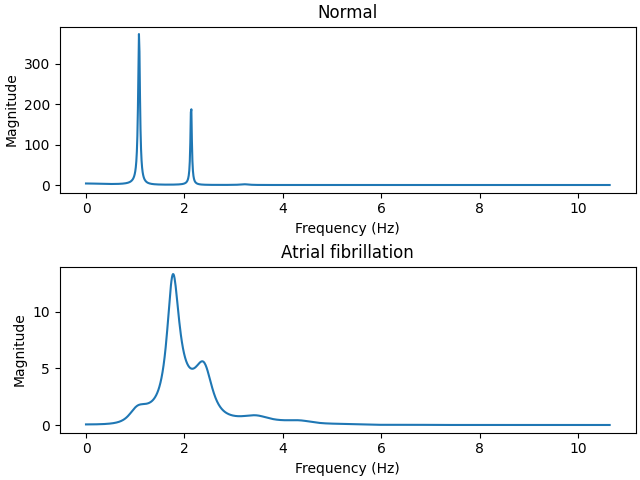

In [19]:
py1, f1 = ar_psd(ppg1, 20, fs)
py2, f2 = ar_psd(ppg2, 20, fs)

plt.figure(constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(f1, py1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title(ttl[0])
plt.subplot(2,1,2)
plt.plot(f2, py2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title(ttl[1])

**Question 3.4.** Estimate the entropy of the PSD of each signal, using:

*p = py / sum(py)*

*entropy = sum(-p * log(p))*

where py is the vector of PSD amplitudes.

**Answer 3.4.** *This can be done as follows:*

In [20]:
p1 = py1 / np.sum(py1)
ent1 = np.sum(-p1 * np.log(p1))

p2 = py2 / np.sum(py2)
ent2 = np.sum(-p2 * np.log(p2))

print("Normal: " + str(ent1))
print("AF    : " + str(ent2))

Normal: 4.006964138961619
AF    : 5.50351507010958


**Question 3.5.** What do these measures (model order, variance ratio, PSD, entropy) tell us about the two signals? Interpret what you have obtained in terms of signal structure/organization.

**Answer 3.5.** *It can be discussed that all measures essentially point to a considerably higher degree of structure/organization in the normal case, compared to the AF case. The normal PPG has a higher AR order and lower excitation-to-signal ratio, both showing that in this case there is more dependence on the preceding values of the signal, rather than on the random excitation input. Regarding the PSDs, the normal case has its power concentrated at a peak around 1 Hz (corresponding to the subject’s heart rate) and its first harmonic, reflecting a very regular cardiac cycle; the AF case has a clearly more disperse profile, without well distinguished peaks – reflecting a much less regular cardiac cycle. The entropy provides a good summary measure of these differences in the PSD, with a lower value for the normal case where the profile is very sparse and organized, compared to a higher value for the AF case where the profile is much more disperse.*

### Experiment 4: Pisarenko harmonic estimation of brain signals
The file `/data/eeg_stim.dat` contains three recordings of scalp electroencephalography (EEG; left frontal electrode, 4-s duration, 512 Hz sampling frequency) from a Parkinson's patient. The patient was also implanted with a deep brain stimulation (DBS) electrode. The first recording corresponds to a baseline (rest) state, the second was obtained during 1-Hz stimulation, and the third during 100-Hz stimulation.

We start by importing and plotting the three signals:

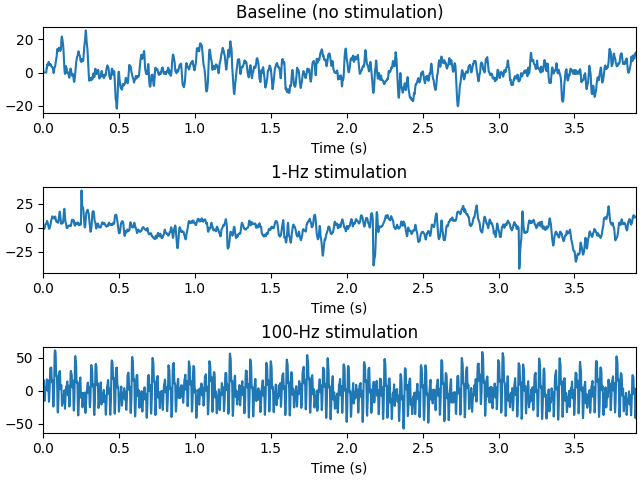

In [21]:
with open(feeg, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    eeg = np.zeros((n,3))
    for k in range(3):
        eeg[:,k] = [float(s[k]) for s in txt]

fs = 512.0 # Hz

plt.figure(constrained_layout=True)
ttl = ['Baseline (no stimulation)', '1-Hz stimulation', '100-Hz stimulation']

t = np.arange(n) / fs

for k in range(3):
    plt.subplot(3,1,k+1)
    plt.plot(t, eeg[:,k])
    plt.xlim(t[0], t[-1])
    plt.xlabel('Time (s)')
    plt.title(ttl[k])

**Question 4.1.** Visually, does any of the stimulation strategies appear to have an effect on the EEG? Which one(s)?

**Answer 4.1.** *This can be visually evaluated by comparing each of the two stimulation cases with the baseline case. In the 1-Hz stimulation, the signal looks relatively similar in temporal structure to the baseline case, whereas in the 100-Hz stimulation there is a much more accentuated difference in structure, and notably, a much clearer, stable periodicity compared to the other cases. This stable periodicity is important because the stimulation itself is periodic (much more regular than the biological activity rhythms generated by the brain, as seen in the appearing and disappearing oscillations in the baseline case). Therefore, we can state that the stimulation at 100 Hz clearly appears to have an effect on the EEG, while the stimulation at 1 Hz only has a mild, or even non-existent, influence.*

As in previous examples, we can apply modeling techniques to quantify the physiological effects under study. Because the DBS is applied in a periodic regime with a specific frequency, it is reasonable to expect a strong sinusoidal presence on the EEG recordings, for any cases where the stimulation does produce a measurable effect. This motivates applying the Pisarenko harmonic retrieval approach, which is implemented below:

In [22]:
def pisarenko(x, p, fs, Aff=0):
    """
    Pisarenko method for harmonic retrieval
    
    x: signal
    p: number of sinusoids
    fs: sampling frequency
    Aff: 0 no graphic display; 1 display
    
    f: vector of sinusoid frequencies
    pp: vector of sinusoid amplitudes
    sg2: noise variance
    
    """
    
    n = len(x)
    
    rx = correlate(x, x, mode='full', method='auto') / n
    
    rxx = np.zeros((2*p+1,2*p+1))
    for k1 in range(2*p+1):
        for k2 in range(2*p+1):
            rxx[k1,k2] = rx[n-1 + abs(k1 - k2)]
    
    u, v = np.linalg.eig(rxx)
    
    sg2 = np.min(u)
    vm = v[:,np.argmin(u)]  # get eigenvector from smallest eigenvalue
    
    r = np.roots(vm)  # find roots of the polynomial
    f = np.angle(r) / (2*np.pi)  # get angle and convert to Hz/sample
    f = f[f > 0]
    
    # Amplitude estimation
    aa = np.zeros((p, len(f)))
    for k in range(p):
        aa[k,:] = np.cos(2*np.pi * (k+1) * f)
    
    r = rx[n:n+p]
    
    pp = np.linalg.lstsq(aa, r, rcond=None)[0]
    f *= fs
    
    if Aff:
        
        plt.figure(constrained_layout=True)
        
        plt.subplot(2,1,1)
        plt.plot(np.arange(1,n+1) / fs, x)
        plt.xlabel('Time (s)')
        plt.title('Signal')
        
        plt.subplot(2,1,2)
        plt.plot([0, fs/2], [sg2, sg2], linewidth=2)
        for k in range(p):
            plt.plot([f[k], f[k]], [sg2, sg2+pp[k]], linewidth=2)
        plt.axis([0, fs/2, 0, 1.2 * (np.max(pp) + sg2)])
        plt.xlabel('Frequency (Hz)')
        plt.title('Pisarenko spectrum')
    
    return f, pp, sg2

**Question 4.2.** Using the above function, apply the Pisarenko method with 5 sinusoids to each of the three recordings, and report the estimated parameters (frequencies, amplitudes, excitation variance).

**Answer 4.2.** *This can be done as follows:*

In [23]:
ns = 5
f1, pp1, sg1 = pisarenko(eeg[:,0], ns, fs)
f2, pp2, sg2 = pisarenko(eeg[:,1], ns, fs)
f3, pp3, sg3 = pisarenko(eeg[:,2], ns, fs)

for k in range(3):
    print(ttl[k])
    print(' - Frequencies: ', end=''); print([f1, f2, f3][k])
    print(' - Amplitudes: ', end=''); print([pp1, pp2, pp3][k])
    print(' - Variance: ', end=''); print([sg1, sg2, sg3][k])

Baseline (no stimulation)
 - Frequencies: [177.97193957 130.10310975  84.36150329  38.88812037   9.02298409]
 - Amplitudes: [7.93840929e-03 5.78003823e-02 3.92010161e-01 4.33325815e+00
 3.96264074e+01]
 - Variance: 0.03289392397050255
1-Hz stimulation
 - Frequencies: [181.14091668 132.82537766  85.02898886  39.60854502   8.72552132]
 - Amplitudes: [2.68542819e-02 1.56214074e-01 1.05168616e+00 9.01849786e+00
 7.09931527e+01]
 - Variance: 0.06120941880176513
100-Hz stimulation
 - Frequencies: [185.88742733 136.09192398  93.56985475  23.53658496  50.79192339]
 - Amplitudes: [  1.335573     7.67389216  39.28443031 265.72686297 154.96105843]
 - Variance: 3.7629418560027723


(using a table may help with reading and interpretation)

**Question 4.3.** Interpret the estimation results -- which stimulation frequency appears to effectively influence brain activity?

**Answer 4.3.** *It can be seen in these results that at baseline, the EEG is dominated by an oscillation near 9 Hz (probably the so-called alpha rhythm) – the amplitude of this sinusoid is considerably stronger than the others. With 1-Hz stimulation the situation is relatively similar, with a dominant frequency at 8.7 Hz, and the four other sinusoids at frequencies quite close to those of the baseline period. In contrast, at 100-Hz stimulation, the signal becomes less dominated by a single frequency, and instead shows three strong oscillations at 23.5, 50.8 and 93.6 Hz (and none at all around 9 Hz). Thus, in agreement with our previous visual insights, it appears that it is the 100-Hz stimulation that has a measurable impact on brain activity.*

### Have a good session, and don't hesitate to ask questions!